In [1]:
%load_ext autoreload
%autoreload 2
from covid_constants_and_util import *
import helper_methods_for_aggregate_data_analysis as helper
import pandas as pd
import os
import matplotlib.pyplot as plt
import json
import datetime
import scipy
import time

JUST_TESTING = False

Setting numpy cores to 1
Running code on rambo.stanford.edu; at Stanford=True


ERROR:fbprophet:Importing plotly failed. Interactive plots will not work.


In [2]:
COLS_FROM_CORE_PLACES = ['safegraph_place_id', 'parent_safegraph_place_id', 'location_name', 'safegraph_brand_ids', 
                         'brands', 'top_category', 'sub_category', 'naics_code', 'latitude', 'longitude', 'street_address',
                         'city', 'region', 'postal_code', 'open_hours']
COLS_FROM_CORE_PLACES_FOOTPRINT = ['safegraph_place_id', 'polygon_class', 'area_square_feet']
COLS_FROM_WEEKLY_PATTERNS = ['safegraph_place_id', 'poi_cbg', 'visitor_home_cbgs', 'visitor_daytime_cbgs', 
                             'visitor_country_of_origin', 'distance_from_home', 'median_dwell', 'bucketed_dwell_times']

In [3]:
core_poi_df = helper.load_core_places_data(COLS_FROM_CORE_PLACES)

Loading /dfs/scratch2/second_safegraph_homes/all_aggregate_data/raw_safegraph_data/core_places/2020/10/core_poi-part1.csv.gz
[########################################] | 100% Completed |  9.8s
Loading /dfs/scratch2/second_safegraph_homes/all_aggregate_data/raw_safegraph_data/core_places/2020/10/core_poi-part2.csv.gz
[########################################] | 100% Completed |  8.7s
Loading /dfs/scratch2/second_safegraph_homes/all_aggregate_data/raw_safegraph_data/core_places/2020/10/core_poi-part3.csv.gz
[########################################] | 100% Completed |  8.6s
Loading /dfs/scratch2/second_safegraph_homes/all_aggregate_data/raw_safegraph_data/core_places/2020/10/core_poi-part4.csv.gz
[########################################] | 100% Completed |  8.4s
Loading /dfs/scratch2/second_safegraph_homes/all_aggregate_data/raw_safegraph_data/core_places/2020/10/core_poi-part5.csv.gz
[########################################] | 100% Completed |  8.4s
Loading core places info for 533350

In [4]:
footprint_df = helper.load_core_places_footprint_data(COLS_FROM_CORE_PLACES_FOOTPRINT)
ids_in_footprint_but_not_core = set(footprint_df.index) - set(core_poi_df.index)
print("Warning: %i/%i (%.1f%%) POIs in footprint but not core data; dropping these" % 
      (len(ids_in_footprint_but_not_core), len(footprint_df), 100. * len(ids_in_footprint_but_not_core) / len(footprint_df)))
core_poi_df = pd.merge(core_poi_df, footprint_df, how='left', left_index=True, right_index=True, validate='one_to_one')
print("Missing data for footprint columns")
print(pd.isnull(core_poi_df[footprint_df.columns]).mean())

Loading /dfs/scratch2/second_safegraph_homes/all_aggregate_data/raw_safegraph_data/core_places_footprint/August2020Release/SafeGraphPlacesGeoSupplementSquareFeet.csv.gz
[########################################] | 100% Completed | 11.4s
Loaded core places footprint data for 5304326 POIs
Missing data for footprint columns
polygon_class       0.02812
area_square_feet    0.02812
dtype: float64


# Combine Core/Footprint/Weekly data and write out to MSA files

In this section, we process the raw SafeGraph Weekly Patterns data and divide the processing output into separate csv files per metropolitan statistical area (MSA). In processing the data, we:
- Expand the visits_by_each_hour column into one column per hour.
- Correct the visit spikes at the GMT midnight boundary (this is a known error with hourly SafeGraph data).
- Drop parent POIs so we don't double-count visits.
- Add an MSA column based on the POI's census block group (if that information is provided).

In [6]:
# first and last week of the latest Weekly data to process
start_date = datetime.datetime(2021, 2, 3)
end_date = datetime.datetime(2021, 2, 10)
print('Time period: %s to %s (%s)' % (start_date.strftime('%Y-%m-%d'), end_date.strftime('%Y-%m-%d'), end_date - start_date))

Time period: 2021-02-03 to 2021-02-10 (7 days, 0:00:00)


In [ ]:
base = core_poi_df.copy()
while start_date <= end_date:
    week_string = start_date.strftime('%Y-%m-%d')
    print('===== WEEK STRING: %s =====' % week_string)
    weekly_df = helper.load_weekly_patterns_v2_data(week_string, COLS_FROM_WEEKLY_PATTERNS, expand_hourly_visits=True)
    weekly_df = weekly_df.rename(columns={k:f'{week_string}.{k}' for k in weekly_df.columns if not(k.startswith('hourly_visits_'))})
    ids_in_weekly_but_not_core = set(weekly_df.index) - set(base.index)
    print("Warning: %i/%i (%.1f%%) POIs in weekly but not core data; dropping these" % 
          (len(ids_in_weekly_but_not_core), len(weekly_df), 100. * len(ids_in_weekly_but_not_core) / len(weekly_df)))
    # left merge means we are only keeping the POIs that we have core info for
    base = pd.merge(base, weekly_df, how='left', left_index=True, right_index=True, validate='one_to_one')
    print("Missing data for weekly columns")
    print(pd.isnull(base[weekly_df.columns]).mean())
    start_date = start_date + datetime.timedelta(days=7)

In [ ]:
def get_single_poi_cbg_col(base):
    poi_cbg_cols = sorted([col for col in base.columns if col.endswith('poi_cbg')])  # put into temporal order
    current_data = base[poi_cbg_cols[0]].copy()
    print('Processed col %s -> num POIs currently missing CBG: %d' % (poi_cbg_cols[0], np.sum(pd.isnull(current_data))))
    for col_name in poi_cbg_cols[1:]:
        new_data = base[col_name]
        non_null = ~pd.isnull(new_data)
        current_data.loc[non_null] = new_data.loc[non_null]
        print('Processed col %s -> num POIs currently missing CBG: %d' % (col_name, np.sum(pd.isnull(current_data))))
    return current_data

base['single_poi_cbg'] = get_single_poi_cbg_col(base)

In [ ]:
def map_poi_cbg_to_msa_info(x, msa_info):
    if pd.isnull(x):
        return 'Missing POI CBG'
    x_as_int = int(x)
    if x_as_int in msa_info:
        return msa_info[x_as_int]
    return 'Missing ACS data'

acs_d = helper.load_and_reconcile_multiple_acs_data()
cbg2metro_micro = dict(zip(acs_d.census_block_group, acs_d['Metropolitan/Micropolitan Statistical Area']))
cbg2cbsa = dict(zip(acs_d.census_block_group, acs_d['CBSA Title']))
base['poi_metro_micro'] = base['single_poi_cbg'].map(lambda x:map_poi_cbg_to_msa_info(x, cbg2metro_micro))
base['poi_cbsa'] = base['single_poi_cbg'].map(lambda x:map_poi_cbg_to_msa_info(x, cbg2cbsa))
base['poi_cbsa'].value_counts()

In [ ]:
just_in_msas = base[base.poi_metro_micro == 'Metropolitan Statistical Area']
print("%i/%i POIs are in MSAs (%i MSAs total)" % (len(just_in_msas), 
                                                  len(base), 
                                                  len(just_in_msas['poi_cbsa'].unique())))

In [5]:
OUT_DIR = os.path.join(NEW_STRATIFIED_BY_AREA_DIR, '20210125_20210201')
assert os.path.isdir(OUT_DIR)
print(OUT_DIR)

/dfs/scratch2/second_safegraph_homes/all_aggregate_data/stratified_by_metro_area/20210125_20210201


### Write to file: if we're starting a new chunk in stratified_by_metro_area

In [ ]:
grouped_by_msa = just_in_msas.groupby('poi_cbsa')
total_written_out = 0
for msa_name, small_d in grouped_by_msa:
    small_d = small_d.copy().sample(frac=1) # make sure rows in random order. 
    name_without_spaces = re.sub('[^0-9a-zA-Z]+', '_', msa_name)
    filename = os.path.join(OUT_DIR, '%s.csv' % name_without_spaces)
    small_d.to_csv(filename)
    print("Wrote out dataframe with %i POIs to %s.csv" % (len(small_d), name_without_spaces))
    total_written_out += 1
print("Total written out: %i" % total_written_out)

### Write to file: if we're concatenating with existing chunk in stratified_by_metro_area

In [ ]:
grouped_by_msa = just_in_msas.groupby('poi_cbsa')
total_written_out = 0
prev_out_dir = os.path.join(NEW_STRATIFIED_BY_AREA_DIR, '20201026_20201228')
assert prev_out_dir != OUT_DIR
for msa_name, small_d in grouped_by_msa:
    ts = time.time()
    name_without_spaces = re.sub('[^0-9a-zA-Z]+', '_', msa_name)
    filename = os.path.join(OUT_DIR, '%s.csv' % name_without_spaces)
    prev_filename = os.path.join(prev_out_dir, '%s.csv' % name_without_spaces)
    prev_d = pd.read_csv(prev_filename)
    prev_d = prev_d.set_index('safegraph_place_id')
    new_cols = [col for col in small_d.columns if col not in prev_d]
    merged_d = prev_d.merge(small_d[new_cols], how='outer', left_index=True, right_index=True)
    merged_d.to_csv(filename)
    print("Wrote out dataframe with %i POIs to %s.csv [time=%.3fs]" % 
          (len(merged_d), name_without_spaces, time.time()-ts))
    total_written_out += 1
print("Total written out: %i" % total_written_out)

## Test written out MSA files

In [6]:
msa_name = 'Washington_Arlington_Alexandria_DC_VA_MD_WV'
time_period_strings = ['20200302_20200608', '20200615_20200817', '20200824_20201019', '20201026_20210118', '20210125_20210201']
dfs = []
for ts in time_period_strings:
    df = helper.load_dataframe_for_individual_msa(msa_name, version='v2', time_period=ts)
    dfs.append(df)

Loaded 67306 rows for Washington_Arlington_Alexandria_DC_VA_MD_WV in 43.042 seconds
Loaded 72940 rows for Washington_Arlington_Alexandria_DC_VA_MD_WV in 29.862 seconds
Loaded 72148 rows for Washington_Arlington_Alexandria_DC_VA_MD_WV in 25.691 seconds
Loaded 73234 rows for Washington_Arlington_Alexandria_DC_VA_MD_WV in 42.494 seconds
Loaded 62347 rows for Washington_Arlington_Alexandria_DC_VA_MD_WV in 4.710 seconds


In [7]:
all_hours = []
visits_per_hour = []
for df in dfs:
    hourly_visit_cols = [col for col in df.columns if col.startswith('hourly_visits')]
    start_hour_string = hourly_visit_cols[0].split('_')[-1]
    start_year, start_month, start_day, start_hour = start_hour_string.split('.')
    start_hour = datetime.datetime(int(start_year), int(start_month), int(start_day), int(start_hour))
    end_hour_string = hourly_visit_cols[-1].split('_')[-1]
    end_year, end_month, end_day, end_hour = end_hour_string.split('.')
    end_hour = datetime.datetime(int(end_year), int(end_month), int(end_day), int(end_hour))
    if len(all_hours) > 0:
        assert start_hour == (all_hours[-1] + datetime.timedelta(hours=1))
    hours_in_range = helper.list_hours_in_range(start_hour, end_hour)
    all_hours.extend(hours_in_range)
    mat = df[hourly_visit_cols].values
    num_nonnan_per_hour = np.sum(~np.isnan(mat), axis=0)
    num_avg_visits_per_hour = np.nansum(mat, axis=0) / num_nonnan_per_hour
    visits_per_hour.extend(num_avg_visits_per_hour)
    
    print('%s - %s (%d hours) -> num non-nan POIs: avg=%.2f, std=%.2f; avg visits per POI: avg=%.2f, std=%.2f' % 
      (start_hour.strftime('%Y/%m/%d, %H'), end_hour.strftime('%Y/%m/%d, %H'), len(hours_in_range),
       np.mean(num_nonnan_per_hour), np.std(num_nonnan_per_hour), np.mean(num_avg_visits_per_hour), np.std(num_avg_visits_per_hour)))

2020/03/02, 00 - 2020/06/14, 23 (2520 hours) -> num non-nan POIs: avg=54706.80, std=2074.04; avg visits per POI: avg=0.20, std=0.17
2020/06/15, 00 - 2020/08/23, 23 (1680 hours) -> num non-nan POIs: avg=58839.10, std=1437.45; avg visits per POI: avg=0.23, std=0.16
2020/08/24, 00 - 2020/10/25, 23 (1512 hours) -> num non-nan POIs: avg=60773.22, std=619.51; avg visits per POI: avg=0.24, std=0.16
2020/10/26, 00 - 2021/01/24, 23 (2184 hours) -> num non-nan POIs: avg=59149.00, std=1289.13; avg visits per POI: avg=0.21, std=0.16
2021/01/25, 00 - 2021/02/07, 23 (336 hours) -> num non-nan POIs: avg=57081.50, std=115.50; avg visits per POI: avg=0.18, std=0.14


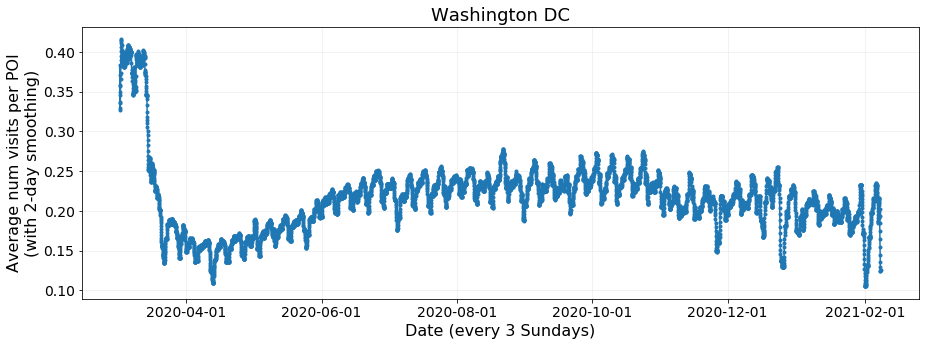

In [8]:
from matplotlib import ticker as tick

fig, ax = plt.subplots(figsize=(15, 5))
x = all_hours
y = apply_smoothing(visits_per_hour, before=24, after=24)
ax.plot_date(x, y, linestyle='-', marker='.')
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.set_xlabel('Date (every 3 Sundays)', fontsize=16)
ax.set_ylabel('Average num visits per POI\n(with 2-day smoothing)', fontsize=16)
ax.set_title('%s' % MSAS_TO_PRETTY_NAMES[msa_name], fontsize=18)
ax.tick_params(labelsize=14)
ax.grid(alpha=0.2)
plt.show()

# Post-processing on MSA files: create time-aggregated

In this section, we aggregate data over many weeks to provide time-aggregated estimates for certain POI attributes. 
- During network inference (see generate_ipf.py), we use time-aggregated estimates of each POI's visitors' home CBG distribution.
- In our model (see model_experiments.py), we use time-aggregated estimates for each POI's dwell time.

Since we use time-aggregated estimates, we do not update these values every time we download new SafeGraph data. As of February 2021, we are using the weeks from 2019/12/30 to 2020/10/19 as the basis for time-aggregated information.

In [ ]:
pop_df = helper.load_dataframe_to_correct_for_population_size(version='v2', verbose=False)
pop_df.head()

In [8]:
# constant info: core, area, aggregated dwell time, aggregated home cbgs
def make_time_aggregated_file_for_msa(msa_name, core_poi_df, pop_df, time_period_strings, dfs=None):
    prefix = '%s_%s' % (time_period_strings[0].split('_')[0], time_period_strings[-1].split('_')[1])
    print('Prefix:', prefix)
    pois_in_msa = set()
    if dfs is None:
        dfs = []
        for ts in time_period_strings:
            df = helper.load_dataframe_for_individual_msa(msa_name, version='v2', time_period=ts)
            pois_in_msa = pois_in_msa.union(df.index)
            dfs.append(df)
    else:
        copied_dfs = []
        for df in dfs:
            copied_dfs.append(df.copy())  # don't want to modify by accident
            pois_in_msa = pois_in_msa.union(df.index)
        dfs = copied_dfs
    
    pois_in_msa = list(sorted(pois_in_msa))
    base = core_poi_df.loc[pois_in_msa].copy()
    parent_ids = set(core_poi_df.parent_safegraph_place_id)
    is_parent = base.index.isin(parent_ids)
    parents = base[is_parent]
    nonparents = base[~is_parent]
    print('In MSA: %d parent POIs; %d non-parent POIs' % (len(parents), len(nonparents)))
    base = nonparents    
    base['poi_cbg'] = np.nan
    for df in dfs:
        visitor_home_cbg_cols = sorted([col for col in df.columns if col.endswith('visitor_home_cbgs')])
        median_dwell_cols = sorted([col for col in df.columns if col.endswith('median_dwell')])
        cols_to_keep = ['single_poi_cbg'] + visitor_home_cbg_cols + median_dwell_cols
        base = pd.merge(base, df[cols_to_keep], how='left', left_index=True, right_index=True, validate='one_to_one')
        poi_cbg_is_nan = pd.isnull(base['poi_cbg'])  # update poi_cbg data that is still null
        base['poi_cbg'][poi_cbg_is_nan] = base['single_poi_cbg'][poi_cbg_is_nan]  # each df has a single_poi_cbg column
        base = base.drop(columns=['single_poi_cbg'])
        
    visitor_home_cbg_cols = [col for col in base.columns if col.endswith('visitor_home_cbgs')]
    print('Found %d visitor home CBG columns' % len(visitor_home_cbg_cols))
    is_null_mat = pd.isnull(base[visitor_home_cbg_cols])
    base['num_weeks_with_visitor_home_cbgs'] = np.sum(~is_null_mat, axis=1)
    periods_to_include = [c[:10] for c in visitor_home_cbg_cols]  # only keep date string
    base = helper.aggregate_visitor_home_cbgs_over_months(base, population_df=pop_df, 
                                                cutoff_year=None, periods_to_include=periods_to_include)
    base = base.rename(columns={k:'%s_%s' % (prefix, k) for k in ['aggregated_cbg_population_adjusted_visitor_home_cbgs', 
          'aggregated_visitor_home_cbgs']})

    median_dwell_cols = [col for col in base.columns if col.endswith('median_dwell')]
    print('Found %d median dwell columns' % len(median_dwell_cols))
    is_null_mat = pd.isnull(base[median_dwell_cols])
    base['num_weeks_with_median_dwell'] = np.sum(~is_null_mat, axis=1)
    base['%s_median_of_median_dwell' % prefix] = np.nanmedian(base[median_dwell_cols].values, axis=1)
    
    cols_to_drop = [col for col in base.columns if '.' in col]  # time-varying are <date>.<col_name>
    base = base.drop(columns=cols_to_drop)
    for k in ['%s_aggregated_cbg_population_adjusted_visitor_home_cbgs' % prefix, 
              '%s_aggregated_visitor_home_cbgs' % prefix]:
        base[k] = base[k].map(lambda x:json.dumps(dict(x))) # cast to json so properly saved in CSV. 
    path_to_csv = os.path.join(NEW_STRATIFIED_BY_AREA_DIR, 'time_aggregated/%s_%s.csv' % (prefix, msa_name))
    print('Saving at', path_to_csv)
    base.to_csv(path_to_csv)
    return base

In [16]:
stratified_by_msa_dir = os.path.join(NEW_STRATIFIED_BY_AREA_DIR, '20200824_20201019')
fns = os.listdir(stratified_by_msa_dir)
va_msas = []
for fn in fns:
    msa = fn.split('.')[0]  # drop .csv
    states = msa.split('_')[1:]
    if 'VA' in states:
        va_msas.append(msa)
print('Found %d MSAs that overlap with VA' % len(va_msas))
print(va_msas)

Found 11 MSAs that overlap with VA
['Staunton_Waynesboro_VA', 'Winchester_VA_WV', 'Richmond_VA', 'Blacksburg_Christiansburg_Radford_VA', 'Washington_Arlington_Alexandria_DC_VA_MD_WV', 'Charlottesville_VA', 'Roanoke_VA', 'Lynchburg_VA', 'Kingsport_Bristol_Bristol_TN_VA', 'Harrisonburg_VA', 'Virginia_Beach_Norfolk_Newport_News_VA_NC']


In [ ]:
time_period_strings = ['20191230_20200224', '20200302_20200608', '20200615_20200817', '20200824_20201019']
for msa_name in va_msas:
    make_time_aggregated_file_for_msa(msa_name, core_poi_df, pop_df, time_period_strings, dfs=None)